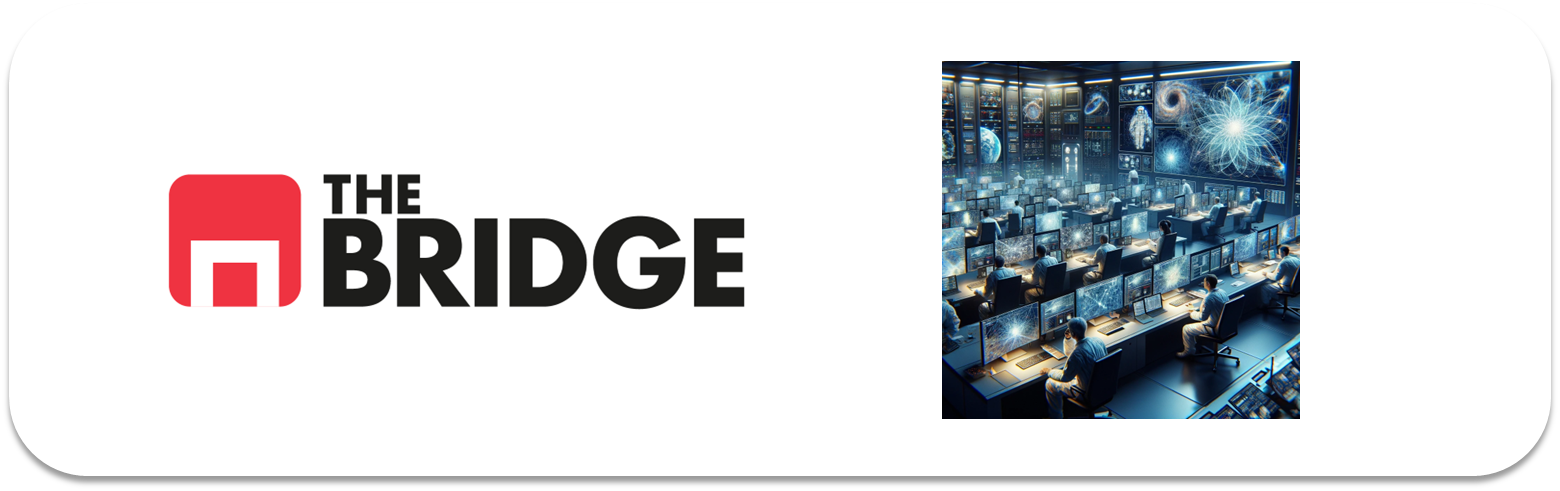

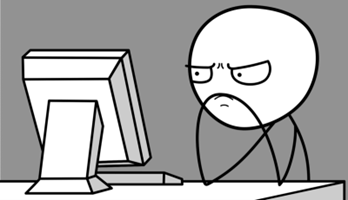

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from keras import layers
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [3]:
train_path = "./data/apples/train"
x_train, y_train = read_data(train_path)

test_path = "./data/apples/test"
x_test, y_test = read_data(test_path)

Braeburn
CrimsonSnow
Golden1
Golden2
Golden3
GrannySmith
PinkLady
Red1
Red2
Red3
RedDelicious
RedYellow1
RedYellow2
Braeburn
CrimsonSnow
Golden1
Golden2
Golden3
GrannySmith
PinkLady
Red1
Red2
Red3
RedDelicious
RedYellow1
RedYellow2


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [4]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

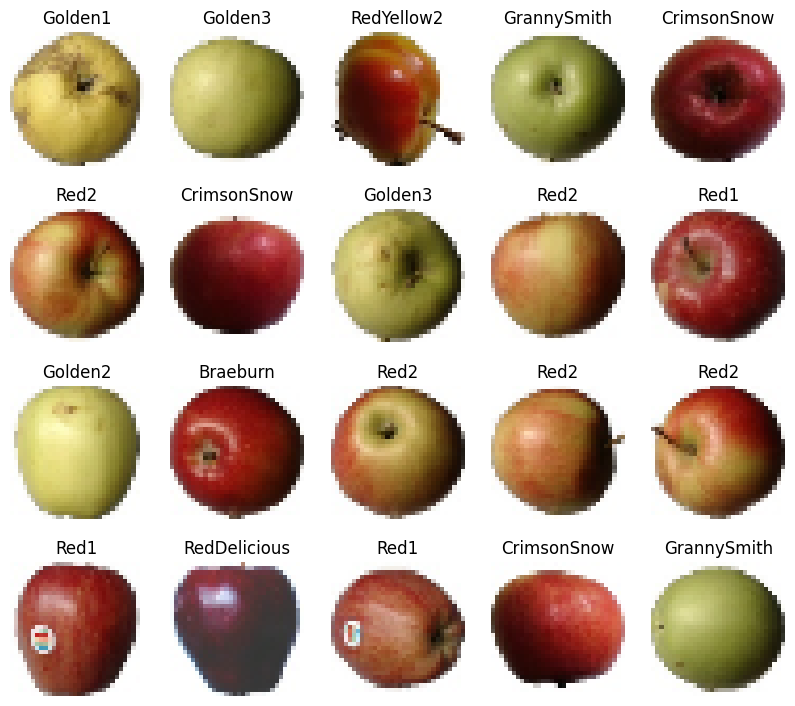

In [5]:
indices = np.random.randint(0,len(x_train),20)
show_images_batch(x_train[indices], names = y_train[indices], n_cols = 5)

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [6]:
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (6404, 32, 32, 3)
y_train shape: (6404,)


Train set contiene un total de 6404 imágenes, de 32 x 32 píxeles. Son imágenes a color (3 canales).

In [7]:
y_train = pd.Series(y_train)
y_train.value_counts(True)

RedYellow2      0.104934
Braeburn        0.076827
Golden2         0.076827
GrannySmith     0.076827
Red1            0.076827
Red2            0.076827
RedYellow1      0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

Los datos están bastante equilibrados. La categoría con mayor cantidad de manzanas es `RedYellow2` con un 10% de los datos y el resto con un 7%.

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [8]:
x_train = x_train / 255
x_test = x_test / 255

x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train, random_state=42)
x_test_shuffled, y_test_shuffled = shuffle(x_test, y_test, random_state=42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [9]:
apples_number_dict = {
    'RedYellow2': 0,
    'Braeburn': 1,
    'Golden2': 2,
    'GrannySmith': 3,
    'Red1': 4,
    'Red2': 5,
    'RedYellow1': 6,
    'RedDelicious': 7,
    'Golden3': 8,
    'Golden1': 9,
    'PinkLady': 10,
    'CrimsonSnow': 11,
    'Red3': 12
}

# Diccionario invertido para la clasificación
int_to_class = {v: k for k, v in apples_number_dict.items()}

y_train = y_train.map(apples_number_dict)
y_test = pd.Series(y_test).map(apples_number_dict)

y_train_shuffled = y_train_shuffled.map(apples_number_dict)
y_test_shuffled = pd.Series(y_test_shuffled).map(apples_number_dict)

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [10]:
X_test_224 = []
y_test_224 = []
TEST_PATH = "./data/apples/test"

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        X_test_224.append(img)
        y_test_224.append(category)

# Transformamos a numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

In [11]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

In [12]:
seleccion = np.random.randint(0,len(X_test_224),20)
predictions = base_model.predict(X_test_224[seleccion])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


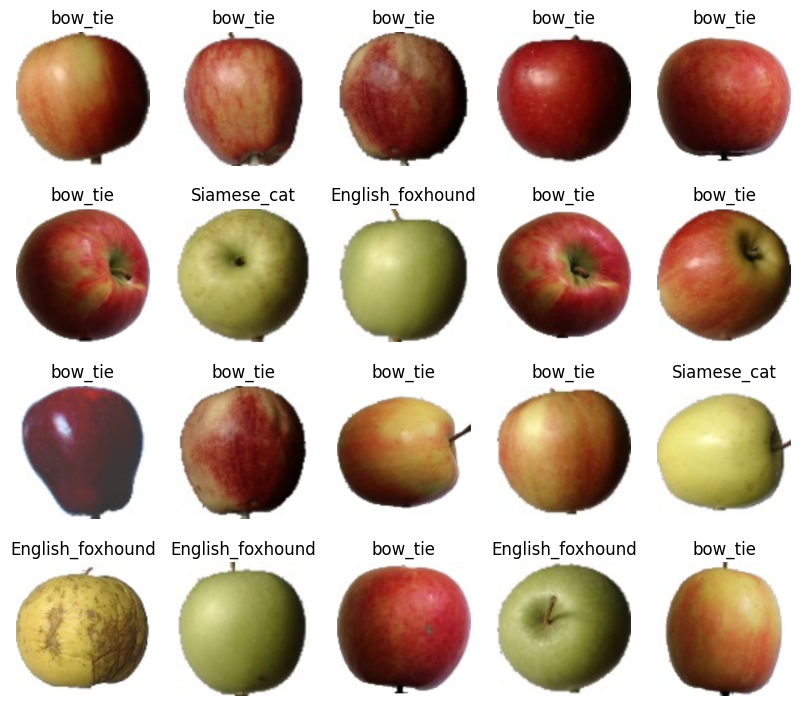

In [13]:
clase = [decodificado[0][1] for decodificado in decode_predictions(predictions)]
show_images_batch(X_test_224[seleccion], names = clase)

No sirve estse clasificador

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [14]:
from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(input_shape=(32, 32, 3), include_top=False, weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)

x = layers.Dense(units = 300, activation='relu')(x)
x = layers.Dropout(0.5)(x)

X = layers.Dense(units = 13, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=X)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train_shuffled, y_train_shuffled, epochs=50, batch_size=64, validation_split=0.2, callbacks=es)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.4768 - loss: 1.8858 - val_accuracy: 0.9407 - val_loss: 0.2717
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.8990 - loss: 0.3342 - val_accuracy: 0.9859 - val_loss: 0.1063
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9472 - loss: 0.1786 - val_accuracy: 0.9922 - val_loss: 0.0601
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9757 - loss: 0.1010 - val_accuracy: 0.9961 - val_loss: 0.0433
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.9820 - loss: 0.0727 - val_accuracy: 0.9984 - val_loss: 0.0253
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 0.9871 - loss: 0.0560 - val_accuracy: 0.9984 - val_loss: 0.0153
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - accuracy: 0.9834 - loss: 0.0604 - val_accuracy: 0.9992 - val_loss: 0.0123
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.9932 - loss: 0.0345 - val_accu

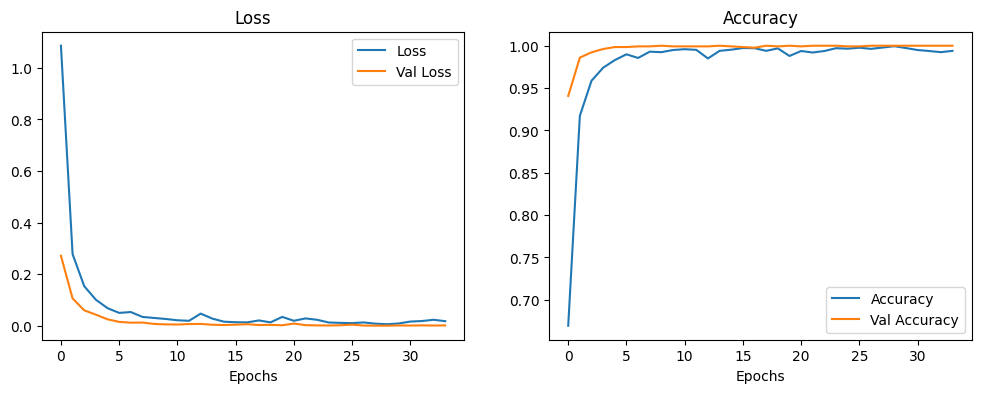

In [17]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

Los valores de accuracy son bastante altos, por lo que nos indica que el modelo ha overfitteado demasiado.

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8770 - loss: 0.5218
Pérdida: 0.5705907344818115, Precisión: 0.8683223724365234
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step
              precision    recall  f1-score   support

  RedYellow2       1.00      0.94      0.97       219
    Braeburn       0.88      0.77      0.82       164
     Golden2       1.00      0.98      0.99       164
 GrannySmith       0.99      0.80      0.89       164
        Red1       0.99      0.81      0.89       164
        Red2       0.54      0.94      0.69       164
  RedYellow1       0.96      0.92      0.94       164
RedDelicious       1.00      1.00      1.00       166
     Golden3       0.73      0.61      0.66       161
     Golden1       0.84      0.99      0.91       160
    PinkLady       0.90      0.82      0.86       152
 CrimsonSnow       0.77      0.92      0.84       148
        Red3       0.97      0.74      0.84       144

    accuracy                           0.87      2134
   macro avg 

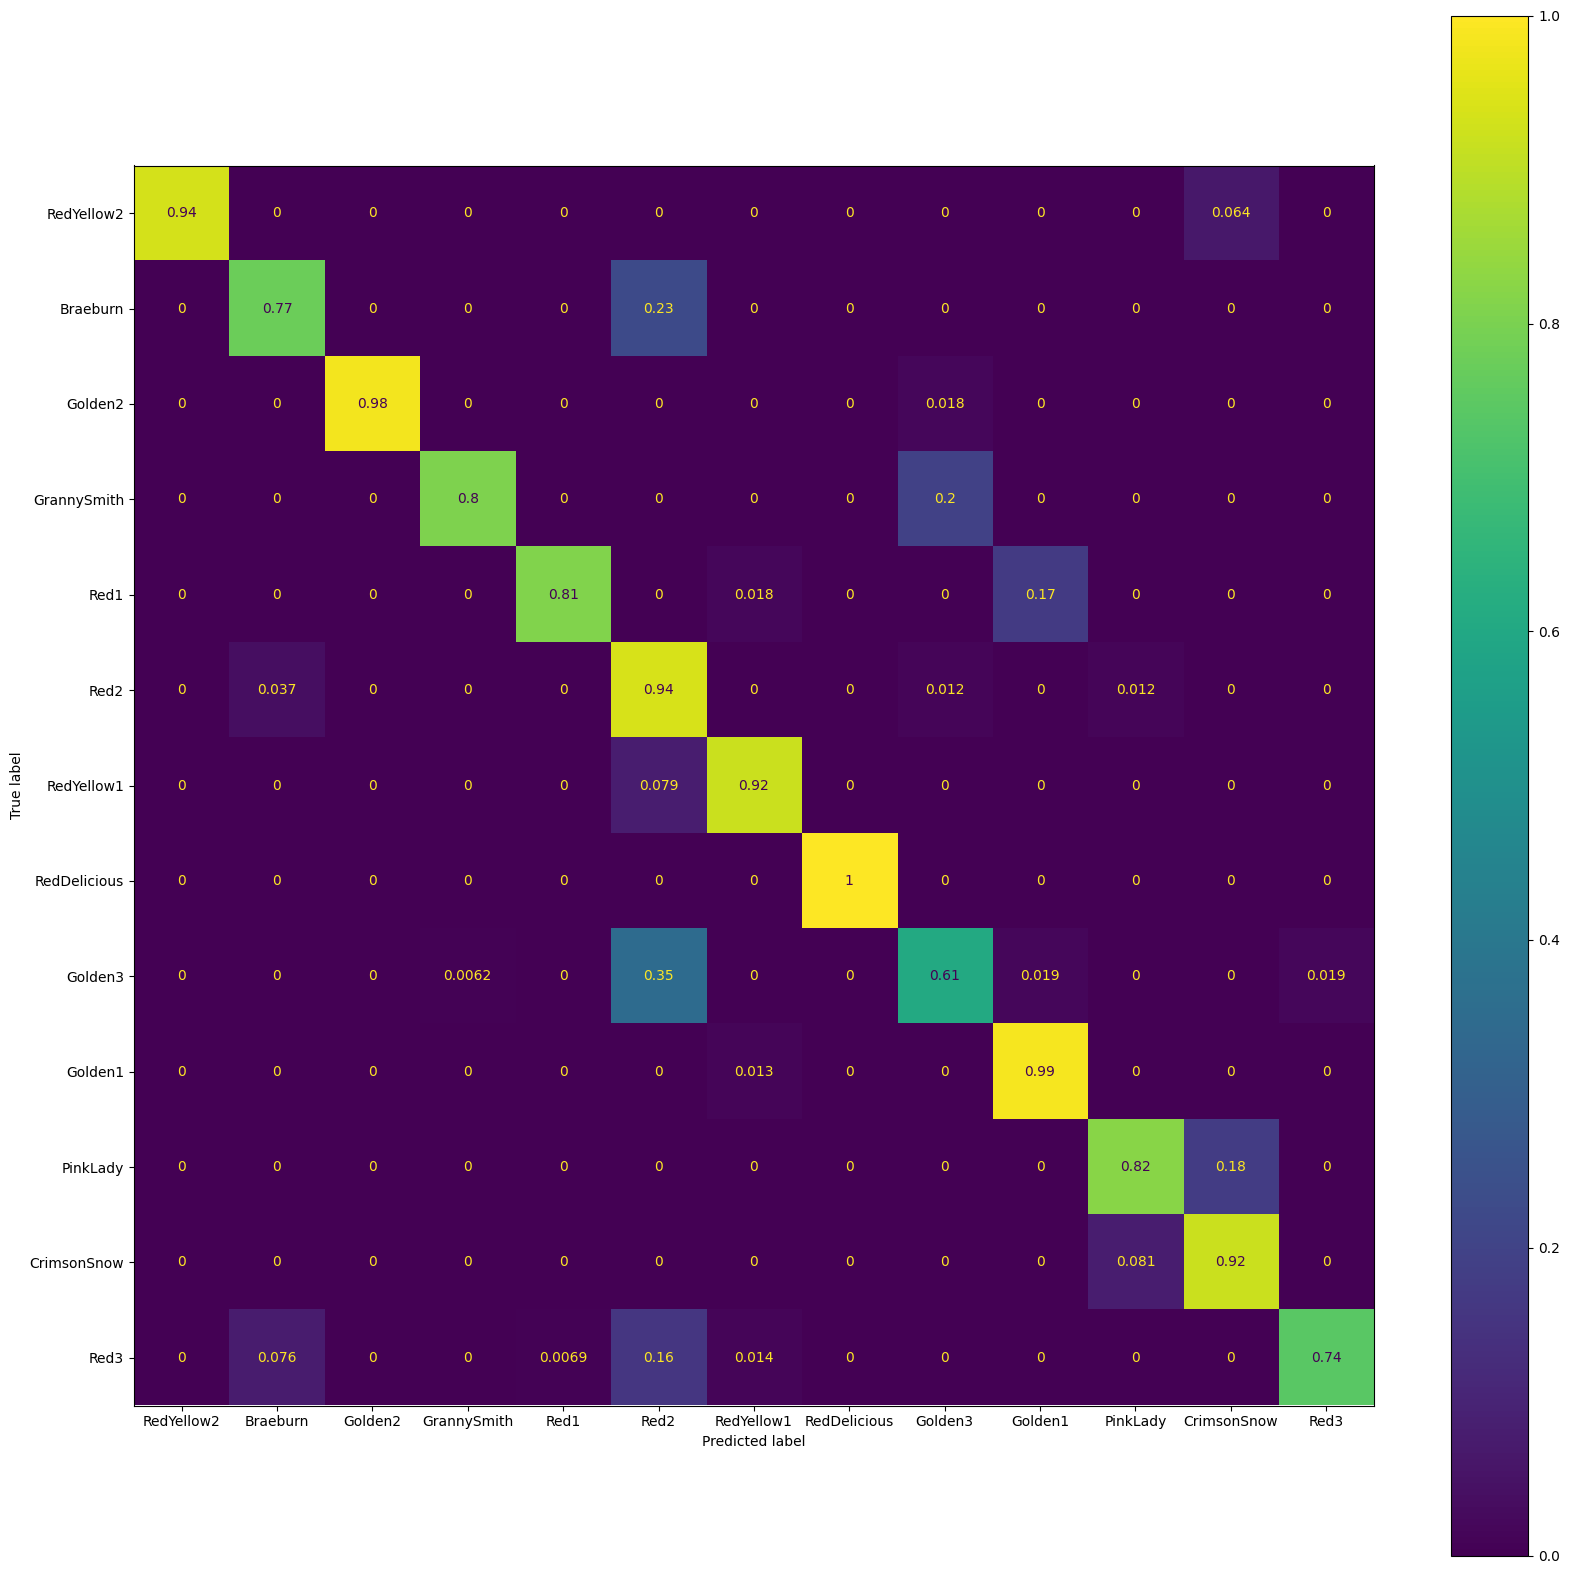

In [18]:
loss, accucary = model.evaluate(x_test_shuffled, y_test_shuffled)
print(f"Pérdida: {loss}, Precisión: {accucary}")
predictions = model.predict(x_test_shuffled)
predictions = np.argmax(predictions, axis=1)
print(classification_report(y_test_shuffled, predictions, target_names=list(apples_number_dict.keys())))

fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test_shuffled, predictions, normalize = 'true',
                                        display_labels=list(apples_number_dict.keys()), ax= axs)
plt.show()

Las clases como `RedYellow2, Braeburn, RedYellow1, RedDelicious, Golden1` las clasifica con apenas errores. El resto de clases tienen una menor precisión como por ejemplo Golden3 que las confunde con Red2, o Red3 que las confunde con Braeburn.

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [21]:
base_model = ResNet50V2(input_shape = (32, 32, 3), include_top = False, weights = None)

x = layers.Flatten()(base_model.output)
    
x = layers.Dense(300, activation='relu')(x)
x = layers.Dropout(rate = 0.5)(x)

x = layers.Dense(13, activation='softmax')(x)
    
model = keras.Model(base_model.input, x)

model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 24,137,973 (92.08 MB)

 Non-trainable params: 45,440 (177.50 KB)

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [22]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train_shuffled, y_train_shuffled, epochs=60, batch_size=64, validation_split=0.2, callbacks=es)

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 94s 862ms/step - acc: 0.6635 - loss: 1.1075 - val_acc: 0.0695 - val_loss: 3.5195
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 703ms/step - acc: 0.8637 - loss: 0.4899 - val_acc: 0.0710 - val_loss: 6.4627
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 61s 752ms/step - acc: 0.8887 - loss: 0.3680 - val_acc: 0.1639 - val_loss: 7.9443
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 688ms/step - acc: 0.8831 - loss: 0.4085 - val_acc: 0.2545 - val_loss: 2.8476
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 669ms/step - acc: 0.9169 - loss: 0.2998 - val_acc: 0.3841 - val_loss: 3.8655
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 670ms/step - acc: 0.9177 - loss: 0.3029 - val_acc: 0.2654 - val_loss: 8.6157
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 674ms/step - acc: 0.8450 - loss: 0.6126 - val_acc: 0.7923 - val_loss: 0.5433
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 668ms/step - acc: 0.9224 - loss: 0.3036 - val_acc: 0.7572 - val_loss: 0.8722
Epoch 9/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 694ms/

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - acc: 0.9848 - loss: 0.0398
Pérdida: 0.046444207429885864, Precisión: 0.9835988879203796
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step
              precision    recall  f1-score   support

  RedYellow2       1.00      1.00      1.00       219
    Braeburn       0.90      1.00      0.95       164
     Golden2       1.00      1.00      1.00       164
 GrannySmith       0.91      1.00      0.95       164
        Red1       1.00      1.00      1.00       164
        Red2       1.00      0.89      0.94       164
  RedYellow1       1.00      1.00      1.00       164
RedDelicious       1.00      1.00      1.00       166
     Golden3       1.00      0.89      0.94       161
     Golden1       1.00      1.00      1.00       160
    PinkLady       1.00      1.00      1.00       152
 CrimsonSnow       1.00      1.00      1.00       148
        Red3       1.00      1.00      1.00       144

    accuracy                           0.98      2134
   macro avg     

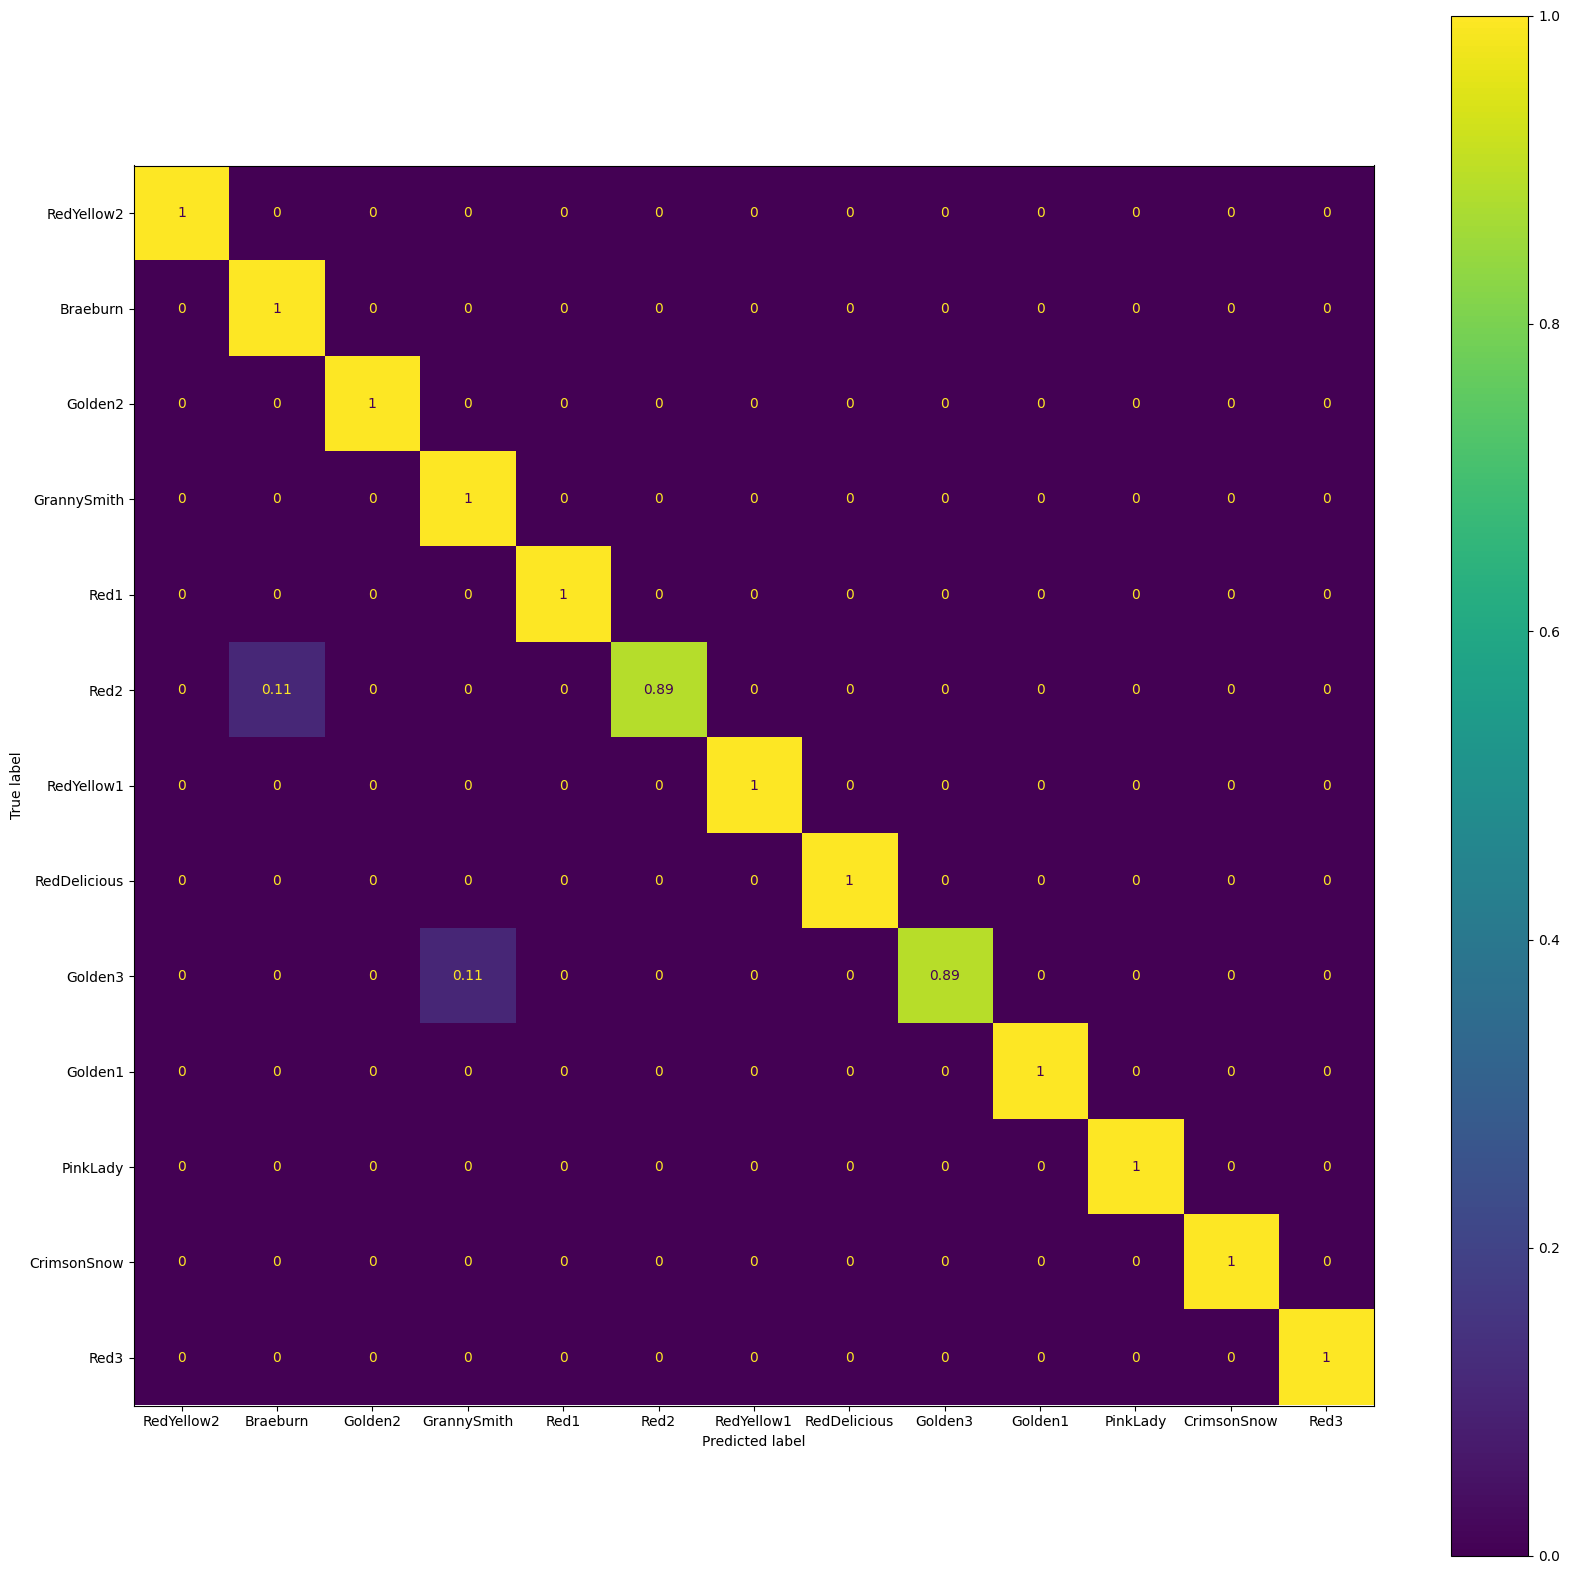

In [23]:
loss, accucary = model.evaluate(x_test_shuffled, y_test_shuffled)
print(f"Pérdida: {loss}, Precisión: {accucary}")
predictions = model.predict(x_test_shuffled)
predictions = np.argmax(predictions, axis=1)
print(classification_report(y_test_shuffled, predictions, target_names=list(apples_number_dict.keys())))

fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test_shuffled, predictions, normalize = 'true',
                                        display_labels=list(apples_number_dict.keys()), ax= axs)
plt.show()

Con el modelo sin pesos conseguimos una clasificación prácticamente perfecta. Las únicas clases que no detecta a la perfección son Golden3 y Red2.